In [2]:
%matplotlib notebook
%load_ext autoreload
%autoreload 1
!hostname
!pwd

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
v031.ib.bridges2.psc.edu
/ocean/projects/asc170022p/mtragoza/mre-pinn/notebooks


In [3]:
import sys, os, pathlib
import numpy as np
import xarray as xr
import torch
torch.backends.cudnn.enabled = True
import matplotlib.pyplot as plt
import seaborn as sns

os.environ['DDEBACKEND'] = 'pytorch'
import deepxde

sys.path.append('..')
%aimport mre_pinn

torch.cuda.is_available()

Using backend: pytorch



True

In [4]:
%autoreload

cohort = mre_pinn.data.PatientCohort(patient_ids=['0006'], xarray_dir='../data/NAFLD')
#cohort = mre_pinn.data.PatientCohort.from_file('../data/NAFLD/NAFLD_2022-11-7.xarrays', xarray_dir='../data/NAFLD')
#cohort.create_xarrays()
#cohort.save_xarrays()
#cohort.metadata
cohort.load_xarrays()
cohort.eval_baseline()

  0%|          | 0/1 [00:00<?, ?it/s]Loading ../data/NAFLD/0006/t1_pre_in.nc
Loading ../data/NAFLD/0006/t1_pre_water.nc
Loading ../data/NAFLD/0006/t1_pre_out.nc
Loading ../data/NAFLD/0006/t1_pre_fat.nc
Loading ../data/NAFLD/0006/t2.nc
Loading ../data/NAFLD/0006/mre_raw.nc
Loading ../data/NAFLD/0006/wave.nc
Loading ../data/NAFLD/0006/mre.nc
Loading ../data/NAFLD/0006/anat_mask.nc
Loading ../data/NAFLD/0006/mre_mask.nc
  0%|          | 0/1 [00:00<?, ?it/s]

  return key in self.data

  return key in self.data



100%|██████████| 1/1 [00:00<00:00,  4.87it/s]


In [5]:
pde = mre_pinn.pde.WaveEquation.from_name('helmholtz', detach=False)
pde

In [21]:
%autoreload

pino = mre_pinn.model.pino.HyperCNN(
    n_channels_in=1,
    n_channels_block=16,
    n_conv_per_block=1,
    n_conv_blocks=5,
    width_factor=2,
    activ_fn='g',
    n_latent=1,
    n_spatial_freqs=128,
    u_omega=10/300,
    u_scale=1e2,
    mu_omega=10/300,
    mu_scale=5e2,
    skip_connect=True,
    dense=True,
    debug=True
)
pino

input		 1 [256 256   4]
conv_in		 16 [256 256   4]
conv_block0	 16 [256 256   4]
pool0		 16 [128 128   2]
conv_block1	 32 [128 128   2]
pool1		 32 [64 64  1]
conv_block2	 64 [64 64  1]
pool2		 64 [32 32  1]
conv_block3	 128 [32 32  1]
pool3		 128 [16 16  1]
conv_block4	 256 [16 16  1]
pool4		 256 [8 8 1]
linear_out	 1


HyperCNN(
  (cnn): CNN(
    (conv_in): Conv3d(1, 16, kernel_size=(1, 1, 1), stride=(1, 1, 1))
    (conv_block0): ConvBlock(
      (conv0): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    )
    (pool0): AvgPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2), padding=0)
    (conv_block1): ConvBlock(
      (conv0): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    )
    (pool1): AvgPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2), padding=0)
    (conv_block2): ConvBlock(
      (conv0): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    )
    (pool2): AvgPool3d(kernel_size=(2, 2, 1), stride=(2, 2, 1), padding=0)
    (conv_block3): ConvBlock(
      (conv0): Conv3d(128, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    )
    (pool3): AvgPool3d(kernel_size=(2, 2, 1), stride=(2, 2, 1), padding=0)
    (conv_block4): ConvBlock(
      (conv0): Conv3d(256, 256, kernel_size=(3, 3, 3), stride=(1, 1, 1

In [24]:
%autoreload

model = mre_pinn.training.PINOModel(cohort, pino, pde, patch_size=None, batch_size=1)
model.compile(
    optimizer='adam',
    lr=1e-2,
    loss_weights=[1e0, 0],
    loss=mre_pinn.training.losses.msae_loss
)   
test_eval = mre_pinn.testing.TestEvaluator(test_every=10, interact=True)

Compiling model...
'compile' took 0.000310 s



Training model...

0         [7.77e+03, 0.00e+00]    [7.77e+03, 0.00e+00]    []  


<IPython.core.display.Javascript object>


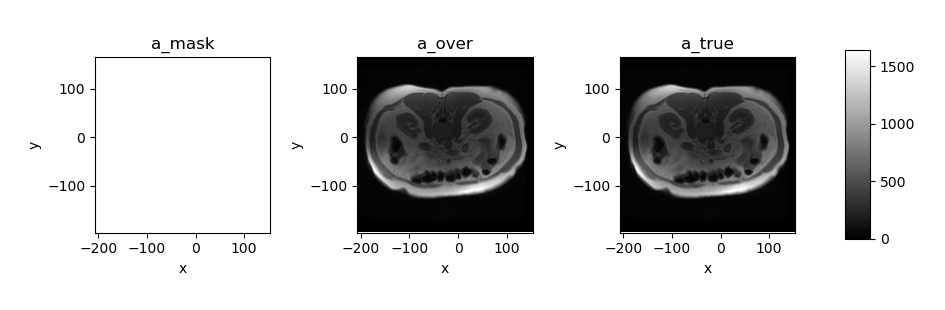

interactive(children=(SelectionSlider(description='part', options=(('real', 0), ('imag', 1)), value=0), Select…

<IPython.core.display.Javascript object>


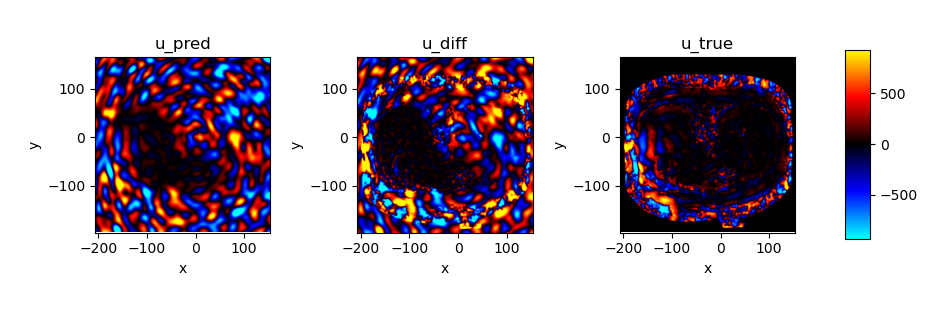

interactive(children=(SelectionSlider(description='part', options=(('real', 0), ('imag', 1)), value=0), Select…

<IPython.core.display.Javascript object>


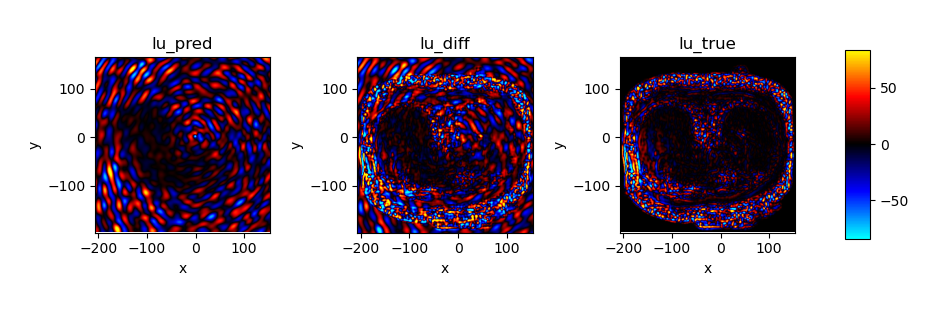

interactive(children=(SelectionSlider(description='part', options=(('real', 0), ('imag', 1)), value=0), Select…

<IPython.core.display.Javascript object>


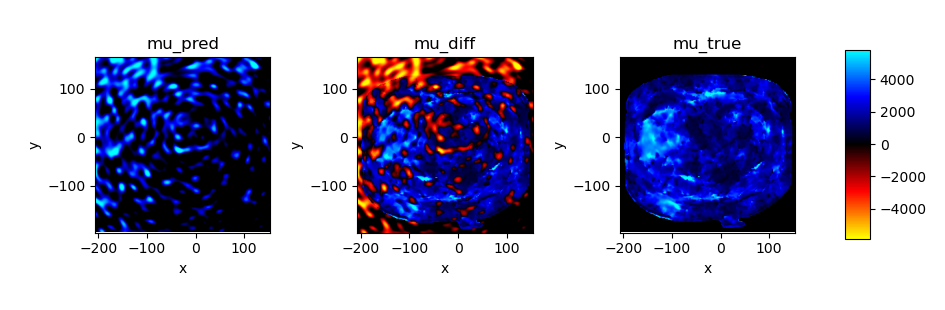

interactive(children=(SelectionSlider(description='part', options=(('real', 0), ('imag', 1)), value=0), Select…

Time spent testing: 73.37%
10        [5.31e+03, 0.00e+00]    [5.31e+03, 0.00e+00]    []  
Time spent testing: 71.40%
20        [3.64e+03, 0.00e+00]    [3.64e+03, 0.00e+00]    []  
Time spent testing: 70.01%
30        [2.81e+03, 0.00e+00]    [2.81e+03, 0.00e+00]    []  
Time spent testing: 69.55%
40        [2.34e+03, 0.00e+00]    [2.34e+03, 0.00e+00]    []  
Time spent testing: 68.93%
50        [2.08e+03, 0.00e+00]    [2.08e+03, 0.00e+00]    []  
Time spent testing: 68.88%
60        [1.91e+03, 0.00e+00]    [1.91e+03, 0.00e+00]    []  
Time spent testing: 68.87%
70        [1.79e+03, 0.00e+00]    [1.79e+03, 0.00e+00]    []  
Time spent testing: 68.78%
80        [1.70e+03, 0.00e+00]    [1.70e+03, 0.00e+00]    []  
Time spent testing: 68.69%
90        [1.63e+03, 0.00e+00]    [1.63e+03, 0.00e+00]    []  
Time spent testing: 68.61%
100       [1.58e+03, 0.00e+00]    [1.58e+03, 0.00e+00]    []  
Time spent testing: 68.33%
110       [1.54e+03, 0.00e+00]    [1.54e+03, 0.00e+00]    []  
Time spent

Time spent testing: 67.51%
930       [1.09e+03, 0.00e+00]    [1.09e+03, 0.00e+00]    []  
Time spent testing: 67.51%
940       [1.08e+03, 0.00e+00]    [1.08e+03, 0.00e+00]    []  
Time spent testing: 67.52%
950       [1.08e+03, 0.00e+00]    [1.08e+03, 0.00e+00]    []  
Time spent testing: 67.52%
960       [1.07e+03, 0.00e+00]    [1.07e+03, 0.00e+00]    []  
Time spent testing: 67.52%
970       [1.13e+03, 0.00e+00]    [1.13e+03, 0.00e+00]    []  
Time spent testing: 67.53%
980       [1.09e+03, 0.00e+00]    [1.09e+03, 0.00e+00]    []  
Time spent testing: 67.52%
990       [1.08e+03, 0.00e+00]    [1.08e+03, 0.00e+00]    []  
Time spent testing: 67.52%
1000      [1.07e+03, 0.00e+00]    [1.07e+03, 0.00e+00]    []  
Time spent testing: 67.53%
1010      [1.07e+03, 0.00e+00]    [1.07e+03, 0.00e+00]    []  
Time spent testing: 67.52%
1020      [1.21e+03, 0.00e+00]    [1.21e+03, 0.00e+00]    []  
Time spent testing: 67.51%
1030      [1.08e+03, 0.00e+00]    [1.08e+03, 0.00e+00]    []  
Time spent

In [ ]:
torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark = True

model.train(100000, display_every=10, callbacks=[test_eval])